<a href="https://colab.research.google.com/github/WilfriKusnadi/superduperimageanalysis/blob/main/analyze_drops.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opencv-python numpy matplotlib scipy


STAGE 1: Drop Detection & Labeling
Upload your drop image:


Saving temp-4 (1).PNG to temp-4 (1) (7).PNG
Processing: temp-4 (1) (7).PNG
Image dimensions: 7759 x 5284
Total contours detected: 399
Creating diagnostic visualization of ALL detected contours...
Diagnostic: Drew circles around 395 detected contours


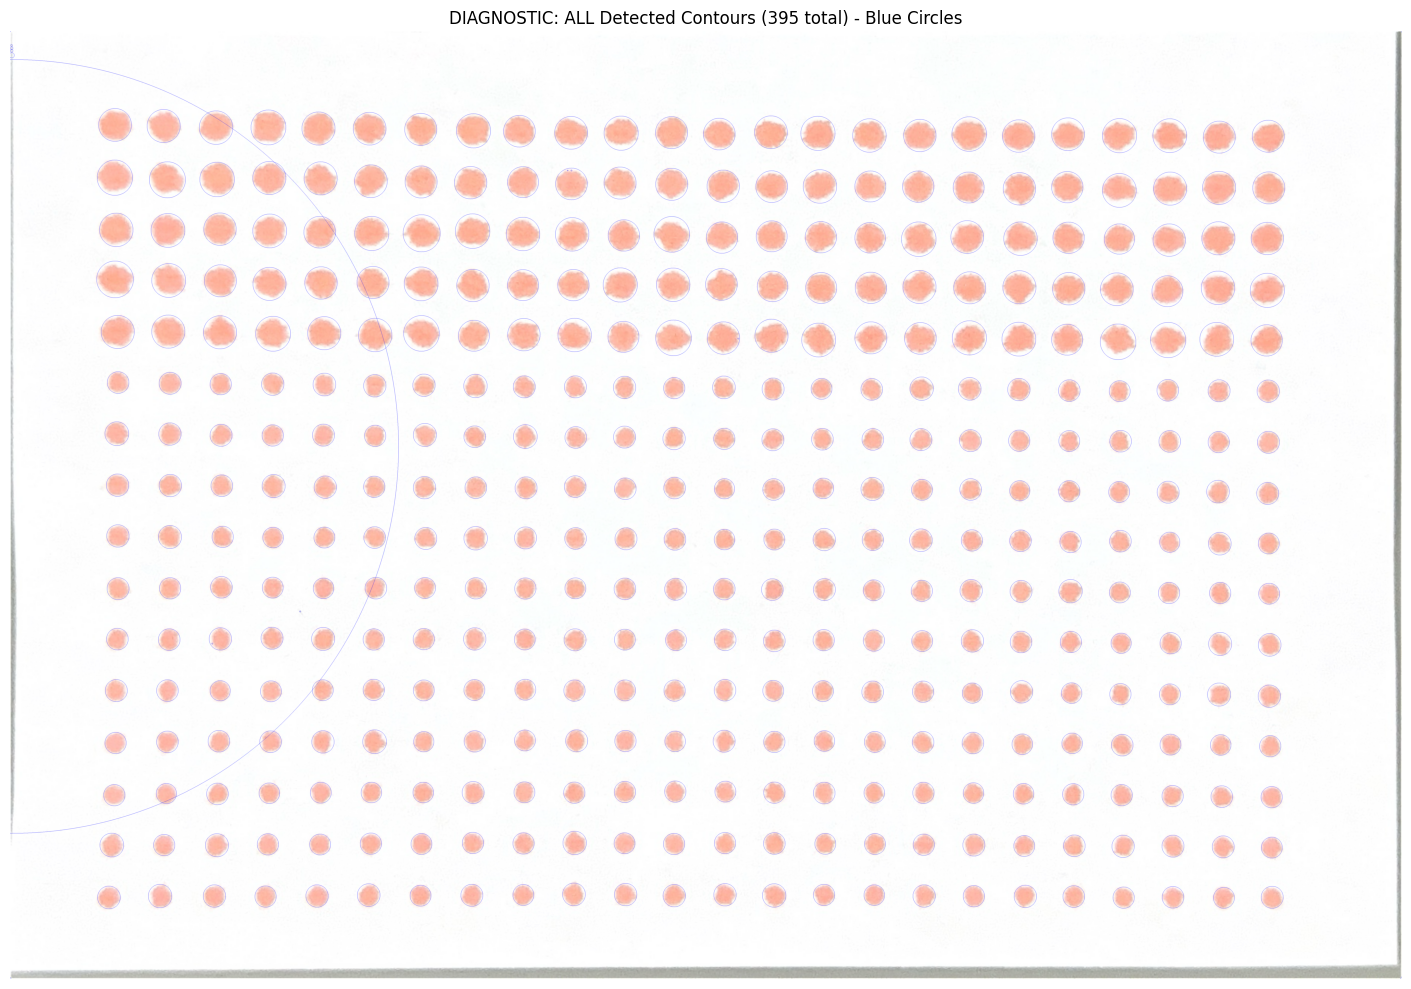


PHASE 2: CORRECTED FILTERING AND RANKING
Step 1: Calculate shape properties and coordinates...
After shape calculation: 394 candidates
Step 2: Edge filtering...
After edge filtering: 389 candidates
Step 3: Proximity filtering...
After proximity filtering: 389 candidates
Step 4: Rank by perimeter deviation from median...
Median perimeter: 381.5 pixels
Selected 384 drops with smallest perimeter deviation
Deviation range: 0.0 to 270.2

FILTERING SUMMARY:
  Initial contours: 394
  After edge filter: 389
  After proximity filter: 389
  Final selection: 384 drops

PHASE 3: GRID ASSIGNMENT

PHASE 4: VISUALIZATION AND OUTPUT
Displaying results...


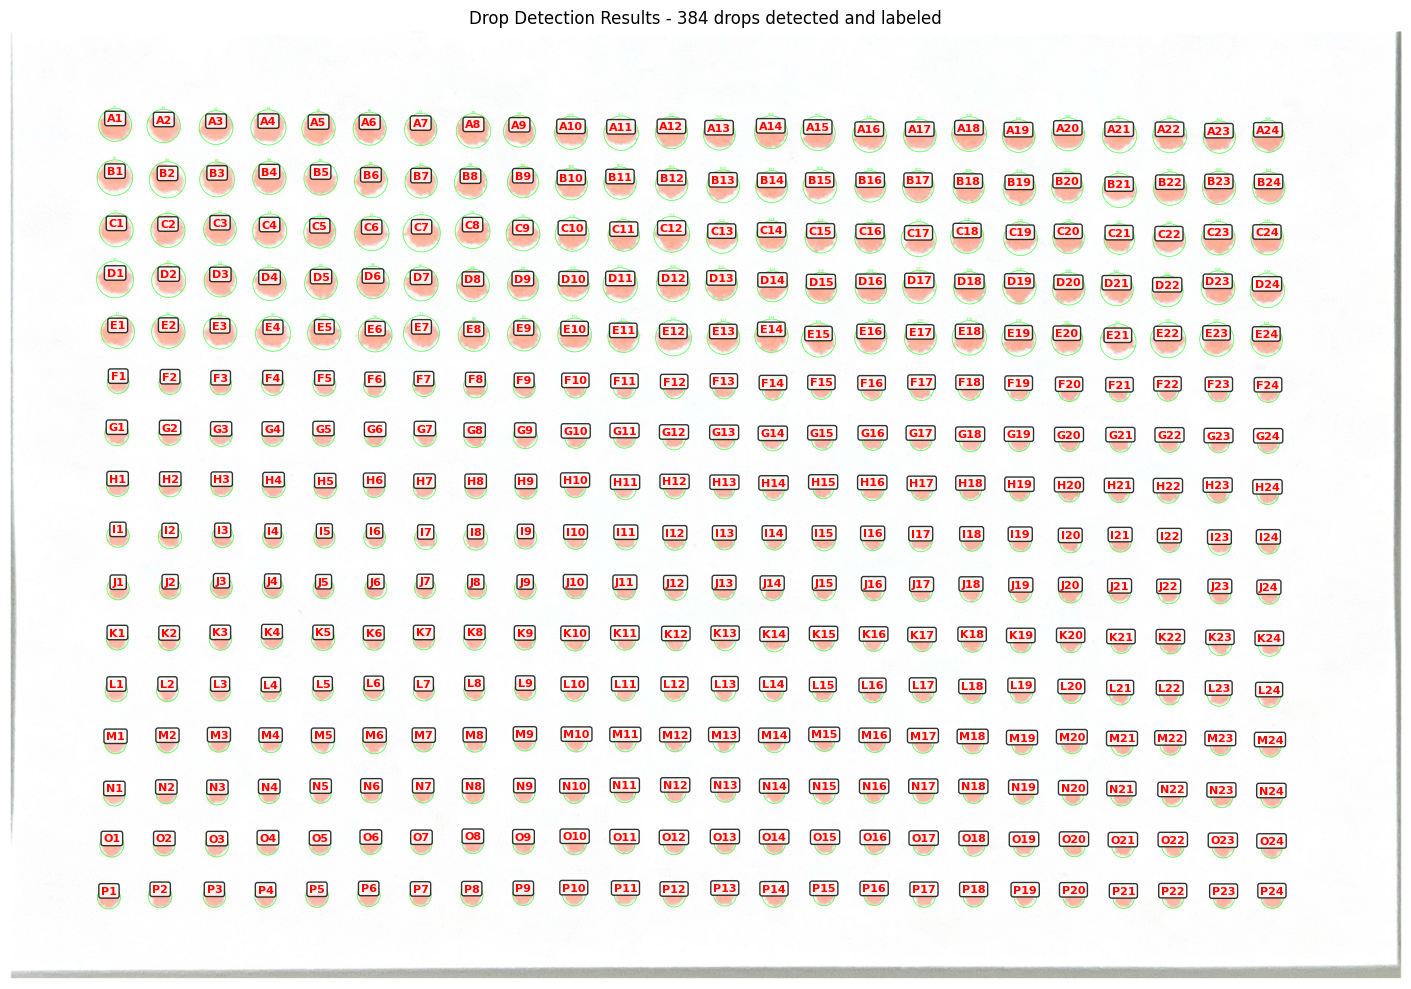

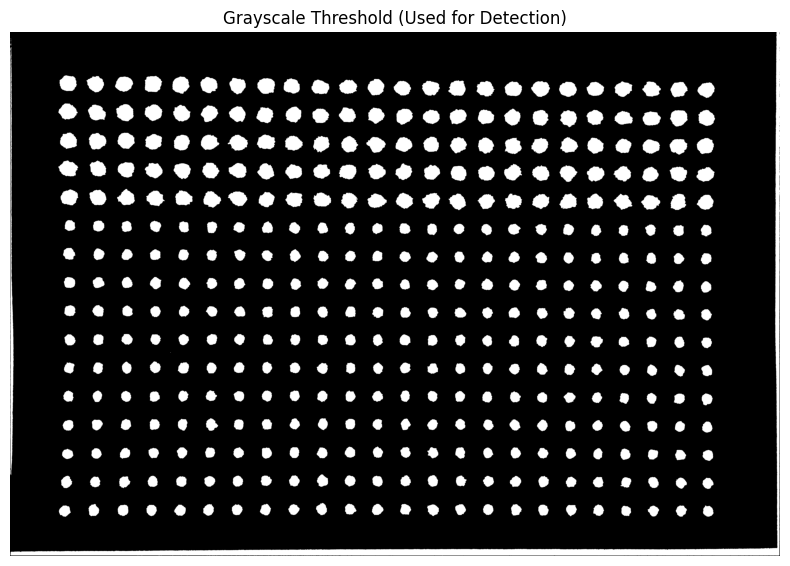


Detected 384 drops

Drop Analysis Results:


,Drop ID,X (px),Y (px),Area (px²),Perimeter (px),Perimeter Deviation,Circularity,Diameter (px)
0,A1,585.6,523.2,21348.5,579.1,197.7,0.800,164.9
1,A2,857.0,529.0,20095.5,581.9,200.5,0.746,160.0
2,A3,1148.6,538.3,20368.0,568.7,187.2,0.791,161.0
3,A4,1440.6,537.6,22677.0,604.8,223.3,0.779,169.9
4,A5,1719.9,543.2,21994.0,593.2,211.7,0.785,167.3
...,...,...,...,...,...,...,...,...
379,P20,5929.0,4824.1,8862.0,383.0,1.6,0.759,106.2
380,P21,6207.5,4830.0,7889.0,357.2,24.2,0.777,100.2
381,P22,6482.8,4828.9,8264.5,375.9,5.6,0.735,102.6
382,P23,6766.4,4831.2,8749.5,381.3,0.2,0.756,105.5



SUMMARY STATISTICS
Median Perimeter: 381.9 px
Average Area: 12074.4 ± 5059.2 px²
Average Perimeter: 440.1 ± 97.0 px
Average Perimeter Deviation: 70.6 ± 88.7 px
Average Circularity: 0.759 ± 0.040
Average Diameter: 121.6 ± 24.5 px

STAGE 1 COMPLETE
Successfully detected and labeled: 384 drops
Grid range: A1 to P24
Results saved to: drop_detection_results_20250822_171643.pkl


In [9]:
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
import pandas as pd
import string
from IPython.display import display, HTML
import io
import base64
import pickle
import json
from datetime import datetime

print("STAGE 1: Drop Detection & Labeling")
print("="*50)

# Upload image
print("Upload your drop image:")
uploaded = files.upload()
image_path = list(uploaded.keys())[0]
print(f"Processing: {image_path}")

# Read image
image = cv2.imread(image_path)
original_image = image.copy()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
height, width = gray.shape

print(f"Image dimensions: {width} x {height}")

# Simple grayscale-based drop detection
blur = cv2.GaussianBlur(gray, (5, 5), 0)
_, gray_thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Find contours using grayscale threshold
contours, _ = cv2.findContours(gray_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(f"Total contours detected: {len(contours)}")

# DIAGNOSTIC: Show ALL detected contours before any filtering
print("Creating diagnostic visualization of ALL detected contours...")
diagnostic_image = original_image.copy()

diagnostic_count = 0
for cnt in contours:
    area = cv2.contourArea(cnt)
    if area >= 1:  # Very minimal filter just to avoid zero-area artifacts
        (x, y), radius = cv2.minEnclosingCircle(cnt)

        # Calculate proper circle radius based on contour dimensions
        max_distance = 0
        center_x, center_y = int(x), int(y)
        for point in cnt:
            px, py = point[0]
            distance = np.sqrt((px - center_x)**2 + (py - center_y)**2)
            max_distance = max(max_distance, distance)

        circle_radius = int(max_distance) + 2
        circle_radius = max(circle_radius, 3)  # Minimum 3 pixels for visibility

        # Draw blue circle for ALL detections
        cv2.circle(diagnostic_image, (center_x, center_y), circle_radius, (255, 0, 0), 1)  # Blue circles
        diagnostic_count += 1

print(f"Diagnostic: Drew circles around {diagnostic_count} detected contours")

# Display diagnostic image
plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(diagnostic_image, cv2.COLOR_BGR2RGB))
plt.title(f'DIAGNOSTIC: ALL Detected Contours ({diagnostic_count} total) - Blue Circles')
plt.axis("off")
plt.tight_layout()
plt.show()

# CORRECTED PHASE 2: FILTERING AND RANKING
print("\n" + "="*50)
print("PHASE 2: CORRECTED FILTERING AND RANKING")
print("="*50)

# Step 1: Calculate shape properties and coordinates
print("Step 1: Calculate shape properties and coordinates...")
candidates = []

for i, cnt in enumerate(contours):
    area = cv2.contourArea(cnt)
    if area < 3:  # Very minimal filtering
        continue

    perimeter = cv2.arcLength(cnt, True)
    if perimeter == 0:
        continue

    (x, y), radius = cv2.minEnclosingCircle(cnt)

    # Calculate shape properties
    circularity = 4 * np.pi * area / (perimeter * perimeter) if perimeter > 0 else 0

    hull = cv2.convexHull(cnt)
    hull_area = cv2.contourArea(hull)
    solidity = area / hull_area if hull_area > 0 else 0

    rect = cv2.minAreaRect(cnt)
    w, h = rect[1]
    aspect_ratio = max(w, h) / min(w, h) if min(w, h) > 0 else float('inf')

    x_rect, y_rect, w_rect, h_rect = cv2.boundingRect(cnt)
    extent = area / (w_rect * h_rect) if (w_rect * h_rect) > 0 else 0

    candidates.append({
        'contour': cnt,
        'area': area,
        'perimeter': perimeter,
        'circularity': circularity,
        'solidity': solidity,
        'aspect_ratio': aspect_ratio,
        'extent': extent,
        'x': x,
        'y': y,
        'radius': radius
    })

print(f"After shape calculation: {len(candidates)} candidates")

# Step 2: Edge filtering
print("Step 2: Edge filtering...")
margin = 40  # 40 pixel margin from edges
edge_filtered = []

for candidate in candidates:
    x, y = candidate['x'], candidate['y']
    if x >= margin and y >= margin and x <= width - margin and y <= height - margin:
        edge_filtered.append(candidate)

print(f"After edge filtering: {len(edge_filtered)} candidates")

# Step 3: Proximity filtering
print("Step 3: Proximity filtering...")
min_distance = 20  # 20 pixel minimum distance between centers

proximity_filtered = []
for candidate in edge_filtered:
    too_close = False

    # Check distance against all already accepted drops
    for existing in proximity_filtered:
        dist = np.sqrt((candidate['x'] - existing['x'])**2 + (candidate['y'] - existing['y'])**2)
        if dist < min_distance:
            too_close = True
            break

    if not too_close:
        proximity_filtered.append(candidate)

print(f"After proximity filtering: {len(proximity_filtered)} candidates")

# Step 4: Rank by perimeter deviation from median and select top 384
print("Step 4: Rank by perimeter deviation from median...")

if len(proximity_filtered) > 0:
    # Calculate median perimeter
    perimeters = [drop['perimeter'] for drop in proximity_filtered]
    median_perimeter = np.median(perimeters)
    print(f"Median perimeter: {median_perimeter:.1f} pixels")

    # Calculate deviation from median for each drop
    for drop in proximity_filtered:
        drop['perimeter_deviation'] = abs(drop['perimeter'] - median_perimeter)

    # Sort by smallest deviation from median (best drops first)
    proximity_filtered.sort(key=lambda x: x['perimeter_deviation'])

    # Select top 384 (or all available if fewer)
    final_drop_count = min(384, len(proximity_filtered))
    selected_384_drops = proximity_filtered[:final_drop_count]

    print(f"Selected {len(selected_384_drops)} drops with smallest perimeter deviation")
    print(f"Deviation range: {selected_384_drops[0]['perimeter_deviation']:.1f} to {selected_384_drops[-1]['perimeter_deviation']:.1f}")
else:
    selected_384_drops = []
    print("No drops found after filtering!")

print(f"\nFILTERING SUMMARY:")
print(f"  Initial contours: {len(candidates)}")
print(f"  After edge filter: {len(edge_filtered)}")
print(f"  After proximity filter: {len(proximity_filtered)}")
print(f"  Final selection: {len(selected_384_drops)} drops")

# GRID ASSIGNMENT (unchanged)
print("\n" + "="*50)
print("PHASE 3: GRID ASSIGNMENT")
print("="*50)

# Step 1: Get x,y coordinates of each drop's center point
drop_centers = []
for drop in selected_384_drops:
    drop_centers.append({
        'x': drop['x'],
        'y': drop['y'],
        'drop_data': drop  # Keep reference to original drop
    })

# Step 2: Sort by Y coordinate (lowest Y = Row A)
drop_centers.sort(key=lambda d: d['y'])  # Lowest Y first

# Step 3: Group into exactly 16 rows of 24 drops each
labeled_drops = []

for row_idx in range(16):
    # Get 24 drops for this row (or remaining drops)
    start_idx = row_idx * 24
    end_idx = min(start_idx + 24, len(drop_centers))

    if start_idx >= len(drop_centers):
        break

    row_drops = drop_centers[start_idx:end_idx]

    # Step 4: Sort this row by X coordinate (lowest X first)
    row_drops.sort(key=lambda d: d['x'])  # Lowest X first, highest X last

    # Step 5: Assign labels A1, A2, ..., A24
    row_letter = chr(ord('A') + row_idx)  # A, B, C, ..., P

    for col_idx, drop_center in enumerate(row_drops):
        drop_center['drop_data']['label'] = f"{row_letter}{col_idx + 1}"
        labeled_drops.append(drop_center['drop_data'])

# VISUALIZATION AND OUTPUT (unchanged)
print("\n" + "="*50)
print("PHASE 4: VISUALIZATION AND OUTPUT")
print("="*50)

result_image = original_image.copy()

for drop in labeled_drops:
    # Get contour and center
    contour = drop['contour']
    center_x, center_y = int(drop['x']), int(drop['y'])

    # Calculate minimum radius to contain all contour pixels
    max_distance = 0
    for point in contour:
        px, py = point[0]
        distance = np.sqrt((px - center_x)**2 + (py - center_y)**2)
        max_distance = max(max_distance, distance)

    # Circle radius: minimum needed to contain all pixels + small buffer
    circle_radius = int(max_distance) + 2
    circle_radius = max(circle_radius, 5)  # Minimum 5 pixels for visibility

    # Draw green circle around drop
    cv2.circle(result_image, (center_x, center_y), circle_radius, (0, 255, 0), 2)

    # Add label above the circle
    label_text = drop['label']

    # Calculate text position (centered above circle)
    text_size = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)[0]
    label_x = center_x - text_size[0] // 2
    label_y = center_y - circle_radius - 5

    # Draw label text
    cv2.putText(result_image, label_text,
                (label_x, label_y),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,           # Font size
                (0, 255, 0),   # Green color
                1,             # Thickness
                cv2.LINE_AA)   # Anti-aliased

# Process data for output
drop_data = []
for drop in labeled_drops:
    diameter = 2 * np.sqrt(drop['area'] / np.pi)
    drop_data.append({
        'label': drop['label'],
        'x': drop['x'],
        'y': drop['y'],
        'area': drop['area'],
        'perimeter': drop['perimeter'],
        'perimeter_deviation': drop['perimeter_deviation'],
        'circularity': drop['circularity'],
        'diameter': diameter
    })

# Create DataFrame
df = pd.DataFrame(drop_data)
if not df.empty:
    df.columns = ['Drop ID', 'X (px)', 'Y (px)', 'Area (px²)', 'Perimeter (px)', 'Perimeter Deviation', 'Circularity', 'Diameter (px)']

    # Round numerical values
    df['Area (px²)'] = df['Area (px²)'].round(1)
    df['Perimeter (px)'] = df['Perimeter (px)'].round(1)
    df['Perimeter Deviation'] = df['Perimeter Deviation'].round(1)
    df['Circularity'] = df['Circularity'].round(3)
    df['Diameter (px)'] = df['Diameter (px)'].round(1)
    df['X (px)'] = df['X (px)'].round(1)
    df['Y (px)'] = df['Y (px)'].round(1)

# Save detection results
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
results_filename = f"drop_detection_results_{timestamp}.pkl"

detection_results = {
    'labeled_drops': labeled_drops,
    'image_path': image_path,
    'image_dimensions': (width, height),
    'median_perimeter': np.median([d['perimeter'] for d in labeled_drops]) if labeled_drops else 0,
    'detection_summary': {
        'total_detected': len(labeled_drops),
        'detection_timestamp': timestamp,
        'algorithm_version': 'perimeter_deviation_v1',
        'max_drops_targeted': 384
    }
}

with open(results_filename, 'wb') as f:
    pickle.dump(detection_results, f)

# Display results with labels
print("Displaying results...")
plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
plt.title(f'Drop Detection Results - {len(labeled_drops)} drops detected and labeled')

# Add labels to each drop on the plot
for drop in labeled_drops:
    plt.text(drop['x'], drop['y']-10, drop['label'],
             color='red', fontsize=8, fontweight='bold',
             ha='center', va='bottom',
             bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))

plt.axis("off")
plt.tight_layout()
plt.show()

# Show the threshold mask for debugging
plt.figure(figsize=(8, 6))
plt.imshow(gray_thresh, cmap='gray')
plt.title('Grayscale Threshold (Used for Detection)')
plt.axis('off')
plt.tight_layout()
plt.show()

# Display data table
if not df.empty:
    print(f"\nDetected {len(labeled_drops)} drops")
    print("\nDrop Analysis Results:")
    display(df)

    # Summary statistics
    print(f"\n" + "="*50)
    print("SUMMARY STATISTICS")
    print("="*50)
    print(f"Median Perimeter: {np.median([d['perimeter'] for d in labeled_drops]):.1f} px")
    print(f"Average Area: {df['Area (px²)'].mean():.1f} ± {df['Area (px²)'].std():.1f} px²")
    print(f"Average Perimeter: {df['Perimeter (px)'].mean():.1f} ± {df['Perimeter (px)'].std():.1f} px")
    print(f"Average Perimeter Deviation: {df['Perimeter Deviation'].mean():.1f} ± {df['Perimeter Deviation'].std():.1f} px")
    print(f"Average Circularity: {df['Circularity'].mean():.3f} ± {df['Circularity'].std():.3f}")
    print(f"Average Diameter: {df['Diameter (px)'].mean():.1f} ± {df['Diameter (px)'].std():.1f} px")

print(f"\nSTAGE 1 COMPLETE")
print(f"Successfully detected and labeled: {len(labeled_drops)} drops")
if labeled_drops:
    print(f"Grid range: {labeled_drops[0]['label']} to {labeled_drops[-1]['label']}")
print(f"Results saved to: {results_filename}")